# 1. 데이터셋 준비

폴더 생성

In [43]:
import os, shutil, random, requests
import pandas as pd
import numpy as np

base_dir = "./dataset"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

for d in [base_dir, train_dir, val_dir]:
    os.makedirs(d, exist_ok=True)
    
for cls in ["covid", "pneumonia", "normal"]:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

COVID-19 X-ray 데이터셋 다운로드

In [ ]:
covid_meta_url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv"
covid_meta_file = "covid_metadata.csv"
if not os.path.exists(covid_meta_file):
    r = requests.get(covid_meta_url)
    open(covid_meta_file, 'wb').write(r.content)

covid_df = pd.read_csv(covid_meta_file)

covid_xrays = covid_df[(covid_df['finding'].str.contains("COVID-19")) &
                       (covid_df['modality']=="X-ray") & 
                       (covid_df['view'].isin(["PA","AP","AP Supine"]))]
covid_files = covid_xrays['filename'].unique().tolist()
print(f"Found {len(covid_files)} COVID X-ray images in dataset.")

if len(covid_files) > 125:
    covid_files = random.sample(covid_files, 125)

covid_raw_base = "https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images"
for fname in covid_files:
    url = f"{covid_raw_base}/{fname}"
    resp = requests.get(url)
    if resp.status_code == 200:
        open(fname, 'wb').write(resp.content)

Found 478 COVID X-ray images in dataset.


In [ ]:
random.seed(42)
random.shuffle(covid_files)

covid_train = covid_files[:97]
covid_val = covid_files[97:]

def copy_covid_images(file_list, dst_dir):
    for fname in file_list:
        src = os.path.join('.', fname) 
        dst = os.path.join(dst_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"❌ COVID 이미지 없음 (건너뜀): {fname}")

copy_covid_images(covid_train, './dataset/train/covid')
copy_covid_images(covid_val, './dataset/val/covid')

print("✅ COVID-19 이미지 학습/검증 분할 복사 완료.")

✅ COVID-19 이미지 학습/검증 분할 복사 완료.


Chest X-ray8 데이터셋 처리

In [ ]:
nih_metadata_path = "Data_Entry_2017_v2020.csv"  
nih_df = pd.read_csv(nih_metadata_path)

image_dir = "./images" 
available_images = set(os.listdir(image_dir))

normal_df = nih_df[nih_df['Finding Labels'] == "No Finding"]
normal_valid = normal_df[normal_df['Image Index'].isin(available_images)]

pneumonia_df = nih_df[nih_df['Finding Labels'].str.contains("Pneumonia")]
pneumonia_valid = pneumonia_df[pneumonia_df['Image Index'].isin(available_images)]

print(f"✅ 'images' 폴더 안에 존재하는 이미지 기준:")
print(f"- 정상(No Finding): {len(normal_valid)}장")
print(f"- 폐렴(Pneumonia): {len(pneumonia_valid)}장")

✅ 'images' 폴더 안에 존재하는 이미지 기준:
- 정상(No Finding): 25822장
- 폐렴(Pneumonia): 525장


데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

nih_metadata_path = "Data_Entry_2017_v2020.csv"
nih_image_dir = "./images"
dataset_base_dir = "./dataset"

nih_df = pd.read_csv(nih_metadata_path)
available_images = set(os.listdir(nih_image_dir))

normal_df = nih_df[nih_df['Finding Labels'] == "No Finding"]
normal_df = normal_df[normal_df['Image Index'].isin(available_images)]
normal_files = normal_df['Image Index'].sample(500, random_state=42).tolist()

pneumonia_df = nih_df[nih_df['Finding Labels'].str.contains("Pneumonia", regex=False)]
pneumonia_df = pneumonia_df[pneumonia_df['Image Index'].isin(available_images)]
pneumonia_files = pneumonia_df['Image Index'].sample(500, random_state=42).tolist()

normal_train, normal_val = train_test_split(normal_files, test_size=109, random_state=42)
pneumonia_train, pneumonia_val = train_test_split(pneumonia_files, test_size=88, random_state=42)

for split in ["train", "val"]:
    for cls in ["normal", "pneumonia"]:
        os.makedirs(os.path.join(dataset_base_dir, split, cls), exist_ok=True)

def copy_images(file_list, src_dir, dst_dir):
    for fname in file_list:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        shutil.copy(src, dst)

copy_images(normal_train, nih_image_dir, os.path.join(dataset_base_dir, "train", "normal"))
copy_images(normal_val, nih_image_dir, os.path.join(dataset_base_dir, "val", "normal"))
copy_images(pneumonia_train, nih_image_dir, os.path.join(dataset_base_dir, "train", "pneumonia"))
copy_images(pneumonia_val, nih_image_dir, os.path.join(dataset_base_dir, "val", "pneumonia"))

print("✅ Normal & Pneumonia 복사 완료! 모든 클래스가 dataset 폴더에 정리되었습니다.")

✅ Normal & Pneumonia 복사 완료! 모든 클래스가 dataset 폴더에 정리되었습니다.


In [44]:
dataset_dir = "./dataset"
splits = ["train", "val"]
classes = ["covid", "pneumonia", "normal"]

for split in splits:
    print(f"\n📂 {split.upper()} SET")
    for cls in classes:
        dir_path = os.path.join(dataset_dir, split, cls)
        if os.path.exists(dir_path):
            count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"- {cls}: {count}장")


📂 TRAIN SET
- covid: 97장
- pneumonia: 412장
- normal: 391장

📂 VAL SET
- covid: 28장
- pneumonia: 88장
- normal: 109장


# 2. Darknet 모델 학습

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DarkNetClassifier(nn.Module):
    def __init__(self):
        super(DarkNetClassifier, self).__init__()
        self.block1 = self._make_block(1, 32)
        self.block2 = self._make_block(32, 64)
        self.block3 = self._make_block(64, 128, use_1x1=True)
        self.block4 = self._make_block(128, 256, use_1x1=True)
        self.block5 = self._make_block(256, 512, use_1x1=True)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 3)

    def _make_block(self, in_c, out_c, use_1x1=False):
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        ]
        if use_1x1:
            mid_c = out_c // 2
            layers += [
                nn.Conv2d(out_c, mid_c, kernel_size=1),
                nn.BatchNorm2d(mid_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
        layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)  
        x = self.block2(x)  
        x = self.block3(x) 
        x = self.block4(x)  
        x = self.block5(x)  
        x = self.global_pool(x)  
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = './dataset/train'
val_dir = './dataset/val'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

print("클래스 인덱스:", train_data.class_to_idx)

클래스 인덱스: {'covid': 0, 'normal': 1, 'pneumonia': 2}


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DarkNetClassifier().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train(model, loader):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    running_loss, correct = 0.0, 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return running_loss / len(loader), acc, all_preds, all_labels

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc, preds, labels = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  🟢 Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  🔵 Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/50
  🟢 Train Loss: 0.9082, Acc: 0.5111
  🔵 Val   Loss: 1.2337, Acc: 0.3822
Epoch 2/50
  🟢 Train Loss: 0.7821, Acc: 0.6033
  🔵 Val   Loss: 0.8156, Acc: 0.5022
Epoch 3/50
  🟢 Train Loss: 0.7230, Acc: 0.6178
  🔵 Val   Loss: 0.9726, Acc: 0.5333
Epoch 4/50
  🟢 Train Loss: 0.6932, Acc: 0.6500
  🔵 Val   Loss: 0.7422, Acc: 0.5956
Epoch 5/50
  🟢 Train Loss: 0.6147, Acc: 0.7267
  🔵 Val   Loss: 0.8341, Acc: 0.4711
Epoch 6/50
  🟢 Train Loss: 0.5511, Acc: 0.7544
  🔵 Val   Loss: 1.0510, Acc: 0.5022
Epoch 7/50
  🟢 Train Loss: 0.5288, Acc: 0.7656
  🔵 Val   Loss: 2.4335, Acc: 0.4489
Epoch 8/50
  🟢 Train Loss: 0.4485, Acc: 0.8000
  🔵 Val   Loss: 3.8053, Acc: 0.4978
Epoch 9/50
  🟢 Train Loss: 0.3286, Acc: 0.8756
  🔵 Val   Loss: 1.2420, Acc: 0.5422
Epoch 10/50
  🟢 Train Loss: 0.3095, Acc: 0.8811
  🔵 Val   Loss: 1.0616, Acc: 0.5422
Epoch 11/50
  🟢 Train Loss: 0.3221, Acc: 0.8689
  🔵 Val   Loss: 2.2352, Acc: 0.5289
Epoch 12/50
  🟢 Train Loss: 0.2146, Acc: 0.9289
  🔵 Val   Loss: 2.6771, Acc: 0.5378
E


📊 Classification Report:
              precision    recall  f1-score   support

       covid       0.95      0.71      0.82        28
      normal       0.60      0.58      0.59       109
   pneumonia       0.48      0.55      0.51        88

    accuracy                           0.58       225
   macro avg       0.68      0.61      0.64       225
weighted avg       0.60      0.58      0.59       225



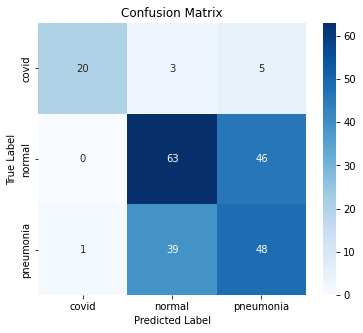

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("\n📊 Classification Report:")
print(classification_report(labels, preds, target_names=train_data.classes))

cm = confusion_matrix(labels, preds)
class_names = train_data.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. Cross Validation 수행

In [31]:
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedKFold

full_dataset = datasets.ImageFolder(root='./dataset/train', transform=transform)
class_names = full_dataset.classes
print("클래스 인덱스:", full_dataset.class_to_idx)

targets = [label for _, label in full_dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n========================")
    print(f"📂 Fold {fold+1}/5")

    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = DarkNetClassifier()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 51):
        train_loss, train_acc = train(model, train_loader)
        val_loss, val_acc, preds, labels = evaluate(model, val_loader)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: 🟢 Train Acc: {train_acc:.4f} | 🔵 Val Acc: {val_acc:.4f}")

    fold_accuracies.append(val_acc)
    print(f"✅ Fold {fold+1} 최종 검증 정확도: {val_acc:.4f}")

avg_acc = np.mean(fold_accuracies)
print("\n========================")
print("✅ 5-Fold Cross-Validation 완료")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1} 정확도: {acc:.4f}")
print(f"\n📈 평균 정확도: {avg_acc:.4f}")

클래스 인덱스: {'covid': 0, 'normal': 1, 'pneumonia': 2}

📂 Fold 1/5
Epoch 10: 🟢 Train Acc: 0.9500 | 🔵 Val Acc: 0.5333
Epoch 20: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.5556
Epoch 30: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.5556
Epoch 40: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6222
Epoch 50: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6167
✅ Fold 1 최종 검증 정확도: 0.6167

📂 Fold 2/5
Epoch 10: 🟢 Train Acc: 0.9444 | 🔵 Val Acc: 0.4944
Epoch 20: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6111
Epoch 30: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6500
Epoch 40: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6167
Epoch 50: 🟢 Train Acc: 0.9208 | 🔵 Val Acc: 0.4556
✅ Fold 2 최종 검증 정확도: 0.4556

📂 Fold 3/5
Epoch 10: 🟢 Train Acc: 0.9347 | 🔵 Val Acc: 0.4778
Epoch 20: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6278
Epoch 30: 🟢 Train Acc: 0.9931 | 🔵 Val Acc: 0.6167
Epoch 40: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6611
Epoch 50: 🟢 Train Acc: 1.0000 | 🔵 Val Acc: 0.6556
✅ Fold 3 최종 검증 정확도: 0.6556

📂 Fold 4/5
Epoch 10: 🟢 Train Acc: 0.9389 | 🔵 Val Acc: 0.5722
Epoch 20: 🟢 Train Ac

# 4. (추가) DenseNet 모델 학습

데이터 준비

In [45]:
from torch.utils.data import  WeightedRandomSampler
import torchvision 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomRotation(degrees=10),        
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),      
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder('/home/cv/jw/HW/dataset/train', transform=train_transforms)
val_dataset   = torchvision.datasets.ImageFolder('/home/cv/jw/HW/dataset/val', transform=val_transforms)

class_counts = [sum([1 for _, label in train_dataset.samples if label == i]) 
                for i in range(len(train_dataset.classes))]
class_weights = [0.0] * len(class_counts)
total_count = float(sum(class_counts))
for i, count in enumerate(class_counts):
    class_weights[i] = total_count / count  
class_weights = torch.tensor(class_weights, dtype=torch.float)

sample_weights = [class_weights[label] for (_, label) in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

(1) 사전학습된 DenseNet-121의 classifier 부분만 학습

In [46]:
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
num_features = model.classifier.in_features  
model.classifier = nn.Linear(num_features, 3)  

for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  
scheduler = None  

for epoch in range(5):  
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

(2) 전체 모델 fine-tuning

In [47]:
for param in model.features.parameters():
    param.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)  

best_val_acc = 0.0
best_model_weights = None
for epoch in range(20): 
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() 

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_weights = model.state_dict()  
    print(f"Epoch {epoch}: Val Accuracy = {val_acc:.4f}")

model.load_state_dict(best_model_weights)
torch.save(model.state_dict(), "best_model.pth")

Epoch 0: Val Accuracy = 0.6178
Epoch 1: Val Accuracy = 0.6578
Epoch 2: Val Accuracy = 0.6844
Epoch 3: Val Accuracy = 0.6667
Epoch 4: Val Accuracy = 0.6578
Epoch 5: Val Accuracy = 0.6889
Epoch 6: Val Accuracy = 0.6844
Epoch 7: Val Accuracy = 0.6489
Epoch 8: Val Accuracy = 0.6578
Epoch 9: Val Accuracy = 0.6178
Epoch 10: Val Accuracy = 0.6622
Epoch 11: Val Accuracy = 0.6533
Epoch 12: Val Accuracy = 0.6222
Epoch 13: Val Accuracy = 0.6356
Epoch 14: Val Accuracy = 0.6444
Epoch 15: Val Accuracy = 0.6222
Epoch 16: Val Accuracy = 0.6178
Epoch 17: Val Accuracy = 0.6222
Epoch 18: Val Accuracy = 0.6178
Epoch 19: Val Accuracy = 0.6222


Confusion Matrix

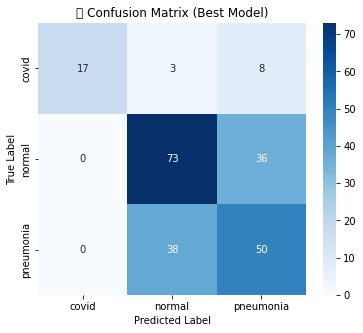

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, 3) 
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("📉 Confusion Matrix (Best Model)")
plt.show()